# PCA: Invariant risk metrics and representation of residuals for bond returns

Diego Alvarez, diego.alvarez@colorado.edu

# Packages

In [153]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

# Background

Throughout this model we will use 3 different sets of term structures <br>
1. Generic US Treasury Yield
2. USD Swap Curve ($\Delta$)
3. USD Swaption Straddles ($\Gamma$)

# Load and Prep Dataa

In [34]:
df = (pd.read_parquet(
    "rates_data.parquet").
    dropna().
    assign(ticker = lambda x: x.ticker.str.split(" ").str[0]))

(df.drop(
    columns = ["source", "sec_type"]).
    pivot(index = "date", columns = "ticker", values = "value").
    dropna().
    head(3))

ticker,DGS1,DGS10,DGS1MO,DGS2,DGS20,DGS3,DGS3MO,DGS5,DGS7,USSO1,...,USSOK,USSVAA01,USSVAA03,USSVAA04,USSVAA05,USSVAA07,USSVAA10,USSVAA15,USSVAA20,USSVAA30
date,,,,,,,,,,,,,,,,,,,,,
2021-05-04,0.06,1.61,0.01,0.16,2.16,0.33,0.02,0.82,1.28,0.0901,...,0.0890,0.2110,0.492,0.7295,0.951,1.299,1.609,1.864,1.9650,2.011
2021-05-05,0.06,1.59,0.01,0.16,2.14,0.32,0.02,0.80,1.25,0.0865,...,0.0856,0.2050,0.484,0.7180,0.929,1.280,1.590,1.847,1.9520,1.997
2021-05-06,0.05,1.58,0.01,0.16,2.14,0.32,0.02,0.81,1.25,0.0861,...,0.0850,0.1985,0.478,0.7140,0.924,1.266,1.575,1.831,1.9335,1.981


Examining how much data is collected

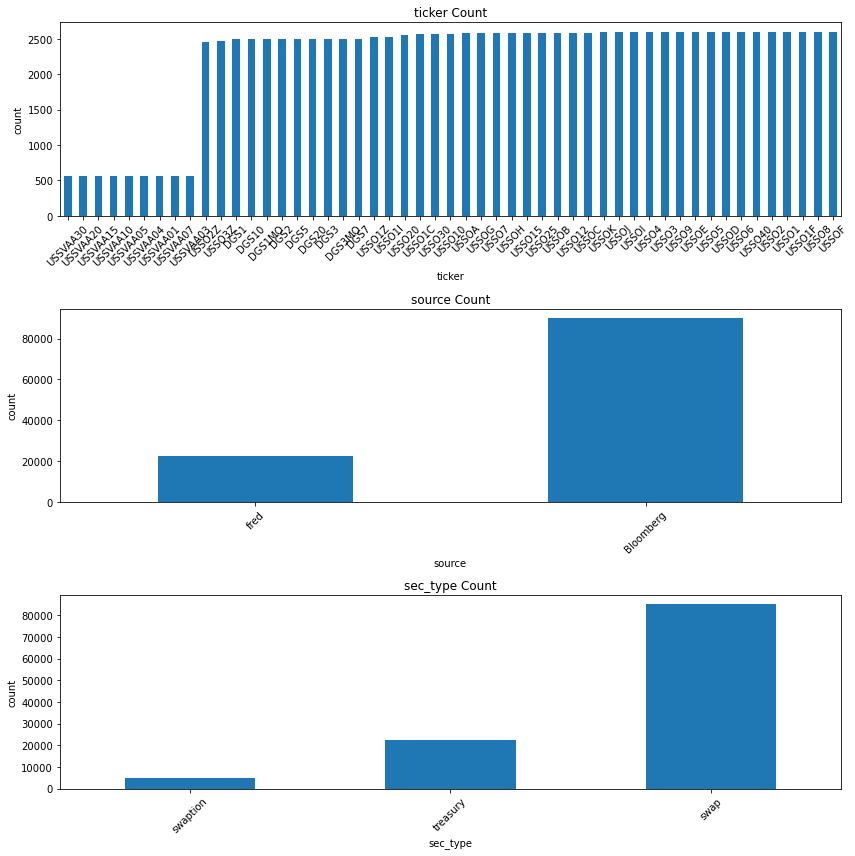

In [42]:
groupby_col = ["ticker", "source", "sec_type"]
fig, axes = plt.subplots(nrows = 3, figsize = (12, 12))

for i, col in enumerate(groupby_col):
    
    (df[
        ["value", col]].
        groupby(col).
        agg("count").
        sort_values("value").
        plot(
            ax = axes[i],
            kind = "bar",
            legend = False,
            title = "{} Count".format(col),
            rot = 45,
            ylabel = "count"))
    
plt.tight_layout()

Looking at first and last dates

In [43]:
(df[
    ["date", "ticker"]].
    groupby("ticker").
    agg(["min", "max"]).
    T)

ticker         DGS1      DGS10     DGS1MO       DGS2      DGS20       DGS3  \
date min 2013-08-23 2013-08-23 2013-08-23 2013-08-23 2013-08-23 2013-08-23   
     max 2023-08-22 2023-08-22 2023-08-22 2023-08-22 2023-08-22 2023-08-22   

ticker       DGS3MO       DGS5       DGS7      USSO1  ...      USSOK  \
date min 2013-08-23 2013-08-23 2013-08-23 2013-08-23  ... 2013-08-23   
     max 2023-08-22 2023-08-22 2023-08-22 2023-08-23  ... 2023-08-23   

ticker     USSVAA01   USSVAA03   USSVAA04   USSVAA05   USSVAA07   USSVAA10  \
date min 2021-05-04 2021-05-04 2021-05-04 2021-05-04 2021-05-04 2021-05-04   
     max 2023-06-30 2023-06-30 2023-06-30 2023-06-30 2023-06-30 2023-06-30   

ticker     USSVAA15   USSVAA20   USSVAA30  
date min 2021-05-04 2021-05-04 2021-05-04  
     max 2023-06-30 2023-06-30 2023-06-30  

[2 rows x 51 columns]

# EDA & Data Cleaning

We need to add in tenors. There really isn't an easy way of doing this exepct by hand

In [104]:
tenors = [
    1, 1/12, 3/12, 2, 3, 5, 7, 10, 20, 10, 
    15, 20, 30, 15/12, 18/12, 21/12, 30, 3/52,
    4, 40, 1/52, 2, 20, 25, 2/52, 3, 11/12,
    1, 3, 4, 5, 7, 5, 6, 7, 8, 1, 10, 9, 1/12,
    2/12, 12, 15, 3/12, 4/12, 5/12, 6/12, 7/12,
    8/12, 9/12, 10/12]

tickers = df.ticker.drop_duplicates().to_list()

tenors = (pd.DataFrame({
    "ticker": tickers,
    "tenor": tenors}))

df_tenor = (df.merge(
    right = tenors, how = "inner", on = ["ticker"]))

Let's just generate some sample curves from the data using random dates

In [133]:
np.random.seed(1234)
random_dates = list(np.random.choice(df.query("sec_type == 'swaption'").date.drop_duplicates(), 3))

In [142]:
df_tenor.query("tenor == 1 & sec_type == 'swaption'")

,date,ticker,value,source,sec_type,tenor
60546,2021-05-04,USSVAA01,0.2110,Bloomberg,swaption,1.0
60547,2021-05-05,USSVAA01,0.2050,Bloomberg,swaption,1.0
60548,2021-05-06,USSVAA01,0.1985,Bloomberg,swaption,1.0
60549,2021-05-07,USSVAA01,0.1920,Bloomberg,swaption,1.0
60550,2021-05-10,USSVAA01,0.1950,Bloomberg,swaption,1.0
...,...,...,...,...,...,...
61104,2023-06-26,USSVAA01,5.4960,Bloomberg,swaption,1.0
61105,2023-06-27,USSVAA01,5.5470,Bloomberg,swaption,1.0
61106,2023-06-28,USSVAA01,5.5230,Bloomberg,swaption,1.0
61107,2023-06-29,USSVAA01,5.6200,Bloomberg,swaption,1.0


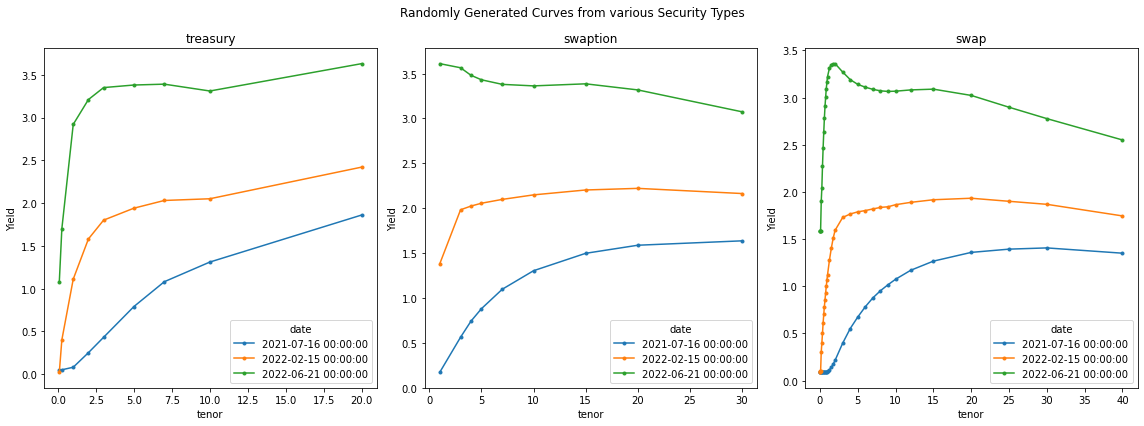

In [137]:
df_plot = (df_tenor.query(
    "date == @random_dates").
    drop(columns = ["source", "ticker"]))

sec_types = df_plot.sec_type.drop_duplicates()
fig, axes = plt.subplots(ncols = len(sec_types), figsize = (16, 6))

for i, sec_type in enumerate(sec_types):
    
    (df_plot.query(
        "sec_type == @sec_type").
        drop(columns = ["sec_type"]).
        pivot(index = "tenor", columns = "date", values = "value").
        plot(
            ax = axes[i],
            style = ".-",
            ylabel = "Yield",
            title = sec_type))
    
plt.suptitle("Randomly Generated Curves from various Security Types")
plt.tight_layout()
plt.show()

# Initial Motivation

The application of Principal Component Analysis is a commonplace method used to decompose yield curve or any term structure, and is the basis for most curve base trading. The ability to segregate different movements of various term structures can provide outlook as well as trading activities. PC (Principal Components) are commonly used on many buy-side and sell-side desks. The PCs also lend themsleves useful because they have economically interpretable meanings and analog tradedable security counterparts. 

Start by analyzing yield curve PCs

In [190]:
def _make_pca_model(df: pd.DataFrame, NCOMPONENTS: int = 3) -> pd.DataFrame:
    
    pca = PCA(n_components = NCOMPONENTS)
    df_longer = (df.drop(
            columns = ["sec_type"]).
            pivot(index = "date", columns = "ticker", values = "value").
            dropna())
    
    pca_fit = pca.fit(df_longer)
    explained_variance_ratio = pca_fit.explained_variance_ratio_
    pca_transform = pca.fit_transform(df_longer)
    
    cols = ["comp{}".format(i + 1) for i in range(NCOMPONENTS)]
    
    df_explain = (pd.DataFrame({
        "variable": cols,
        "value": explained_variance_ratio}).
        assign(data_type = "variance"))
    
    df_fitted = (pd.DataFrame(
        data = pca_transform,
        columns = cols).
        assign(date = df_longer.index).
        melt(id_vars = "date").
        assign(data_type = "fitted_value"))
    
    return(pd.concat(
        [df_fitted, df_explain]))

df_pca_results = (df.drop(
    columns = ["source", "sec_type"]).
    pivot(index = "date", columns = "ticker", values = "value").
    pct_change().
    reset_index().
    melt(id_vars = "date").
    dropna().
    query("value != 0 & value != Inf & value != -Inf").
    merge(
        right = (df[
            ["ticker", "sec_type"]].
            drop_duplicates()),
        how = "left",
        on = ["ticker"]).
    groupby("sec_type").
    apply(_make_pca_model).
    reset_index().
    drop(columns = ["level_1"]))

Analyzing the results

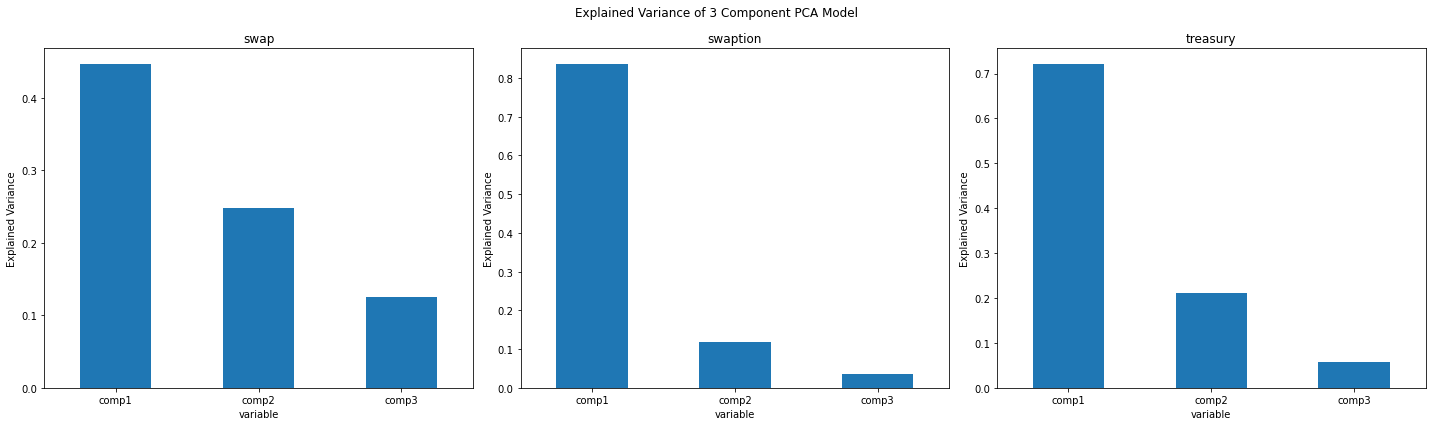

In [202]:
df_exp = (df_pca_results.query(
    "data_type == 'variance'").
    drop(columns = ["data_type", "date"]).
    pivot(index = "variable", columns = "sec_type", values = "value"))

cols = df_exp.columns.to_list()
fig, axes = plt.subplots(ncols = len(cols), figsize = (20,6))
for i, col in enumerate(cols):
    
    (df_exp[
        col].
        plot(
            ax = axes[i],
            kind = "bar",
            title = col,
            ylabel = "Explained Variance",
            rot = 360))
    
fig.suptitle("Explained Variance of 3 Component PCA Model")
plt.tight_layout()
plt.show()

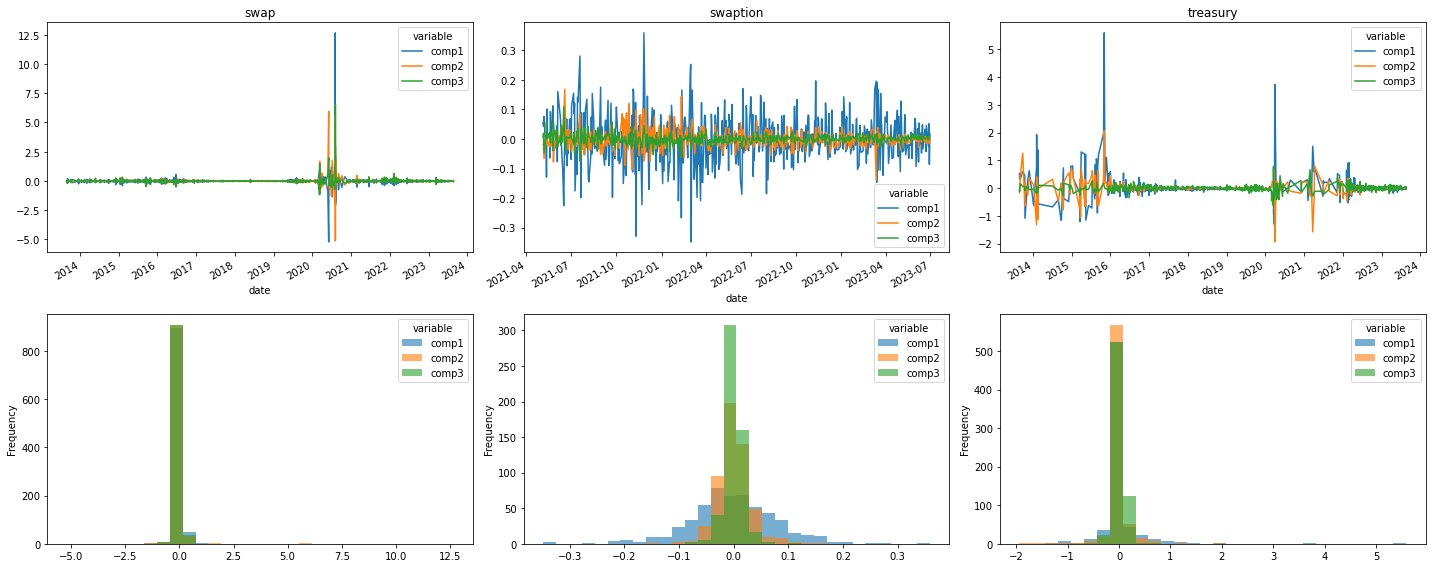

In [229]:
df_fitted = (df_pca_results.query(
    "data_type == 'fitted_value'").
    drop(columns = ["data_type"]).
    pivot(index = "date", columns = ["sec_type", "variable"], values = "value"))

cols = df_fitted.columns.swaplevel(0,1).droplevel().drop_duplicates().to_list()
fig, axes = plt.subplots(ncols = len(cols), nrows = 2, figsize = (20, 8))

for i, col in enumerate(cols):
    
    (df_fitted[
        col].
        dropna().
        plot(
            ax = axes[0,i],
            title = col))
    
    (df_fitted[
        col].
        dropna().
        plot(
            kind = "hist",
            ax = axes[1,i],
            bins = 30,
            alpha = 0.6))
    
plt.tight_layout()
plt.show()